# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.gridspec as gridspec
import math
#import data_transforations as data_tr

import joblib


In [2]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/NearFuture/"

## Models

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from scipy.stats import loguniform


## Scoring

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Functions

In [5]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

In [6]:
#functions for plotting continous features
def plot_histogram_boxplot_kde(data, title="Data Distribution", x_label="Value"):
    """
    Generates a combined plot showing a histogram with KDE, a box plot,
    and summary statistics.

    Args:
        data (array-like): A list, numpy array, or pandas Series of numerical data.
        title (str, optional): The main title for the plot. Defaults to "Data Distribution".
        x_label (str, optional): The label for the x-axis. Defaults to "Value".
    """
    # Convert data to a pandas Series to easily handle potential NaNs and calculations
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Drop NaN values to avoid errors in plotting and calculations
    print('Number of NaN values to be dropped: ',data.isnull().sum())
    data = data.dropna()

    if data.empty:
        print("Warning: Input data is empty or contains only NaN values. Cannot generate plot.")
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics for display
    stats_text = (
        f"Statistics:\n"
        f"-----------\n"
        f"Count: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Set up the plot layout ---
    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    # Define the grid layout: 2 rows, 2 columns.
    # Top row for box plot, bottom row for histogram.
    # Right column for text.
    # Adjust width/height ratios for better spacing.
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           figure=fig, wspace=0.1, hspace=0.05) # Reduced space

    # Create axes for each part of the plot
    ax_hist = fig.add_subplot(gs[1, 0])        # Histogram/KDE at bottom-left
    ax_box = fig.add_subplot(gs[0, 0], sharex=ax_hist) # Box plot at top-left, sharing x-axis
    ax_text = fig.add_subplot(gs[:, 1])        # Text box spanning both rows on the right

    # --- Plot the data ---
    # 1. Histogram and KDE plot (using seaborn for convenience)
    #    'bins="auto"' lets seaborn/numpy choose a suitable number of bins.
    #    'kde=True' adds the Kernel Density Estimate.
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Density")

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1.5, label=f'Median ({median_val:.2f})')
    ax_hist.legend(loc='upper right') # Add legend to histogram plot

    # 2. Box plot
    #    Use seaborn's boxplot for consistency.
    #    'orient='h'' makes it horizontal.
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('') # Remove x-label as it's shared with histogram
    # Remove y-ticks and labels from boxplot for cleaner look
    ax_box.set_yticks([])
    ax_box.set_ylabel('') # Remove y-label

    # Remove ticks and labels from the top x-axis of the box plot
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False) # Remove ticks

    # 3. Statistics Text Box
    ax_text.axis('off') # Turn off the axis lines and ticks
    # Place the text in the center of the text axes
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))

    # --- Final Touches ---
    fig.suptitle(title, fontsize=16) # Add overall title
    # Adjust layout to prevent labels/titles overlapping
    # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    fig.subplots_adjust(top=0.92) # Adjust top margin for suptitle

#--------------------------------------------------------------------------------------------------------------------------------------------

# --- Helper function to plot distribution for a single category ---
# This adapts the logic from the previous function to draw on specific axes
def _plot_single_distribution(data, fig, ax,title="Distribution", x_label="Value"):
    """
    Helper function to draw histogram, KDE, box plot, and stats on a given Axes object
    by creating a nested GridSpec.

    Args:
        data (pd.Series): Numerical data for a single category (NaNs already handled).
        fig (matplotlib.figure.Figure): The main figure object.
        ax (matplotlib.axes.Axes): The main Axes object (from the outer grid)
                                   to draw this category's plot within.
        title (str): Title for this specific subplot.
        x_label (str): Label for the x-axis.
    """

    
  
    # Get the SubplotSpec from the parent Axes object
    ss = ax.get_subplotspec()
    # Turn off the axis frame/ticks for the original 'ax' as its space will be managed by the nested GridSpec
    ax.axis('off')

    if data.empty:
        # If data is empty, add text to the original Axes location
        ax.text(0.5, 0.5, "No data for this category",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=10, color='grey')
        ax.set_title(title, fontsize=10) # Set title on the original Axes
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics
    stats_text = (
        f"N: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"StdDev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Create inset axes within the main 'ax' space using its SubplotSpec ---
    gs_inset = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ss, # Use the SubplotSpec here
                                                width_ratios=[4, 1], height_ratios=[1, 4],
                                                wspace=0.05, hspace=0.05)

    # Create the actual Axes using the main figure and the nested GridSpec indices
    ax_hist = fig.add_subplot(gs_inset[1, 0]) # Histogram at bottom-left
    ax_box = fig.add_subplot(gs_inset[0, 0], sharex=ax_hist) # Box plot at top-left
    ax_text = fig.add_subplot(gs_inset[:, 1]) # Text box on the right

    # --- Plot the data ---
    # 1. Histogram and KDE
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label, fontsize=9) # Slightly smaller font for subplot labels
    ax_hist.set_ylabel("Density", fontsize=9)
    ax_hist.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median ({median_val:.2f})')
    ax_hist.legend(fontsize='x-small', loc='upper right') # Smaller legend

    # 2. Box plot
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])
    ax_box.set_ylabel('')
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False)

    # 3. Statistics Text Box
    ax_text.axis('off')
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=8, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))

    # Set the title for the specific subplot (category) on the original Axes container
    ax.set_title(title, fontsize=10)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# --- Main function to create the grid plot ---
def plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions"):
    """
    Generates a grid of distribution plots (hist, KDE, boxplot, stats)
    for numerical data grouped by a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_col (str): The name of the column with numerical data.
        category_col (str): The name of the column with categorical data.
        main_title (str, optional): The main title for the entire figure.
                                    Defaults to "Grouped Distributions".
    """

    if category_col == 'none':
        
        plot_histogram_boxplot_kde(df[value_col], title=f"Distribution of {value_col}", x_label=value_col)

    else:

        # Check if columns exist
        if value_col not in df.columns:
            print(f"Error: Value column '{value_col}' not found in DataFrame.")
            return
        if category_col not in df.columns:
            print(f"Error: Category column '{category_col}' not found in DataFrame.")
            return

        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs in category column
        # Sort categories for consistent plot order
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # --- Determine grid layout ---
        # Aim for a layout that's roughly square
        ncols = math.ceil(math.sqrt(n_categories))
        nrows = math.ceil(n_categories / ncols)

        # --- Create figure and subplots ---
        # Adjust figsize based on grid size for better readability
        # Increased base size slightly for better spacing within subplots
        fig_width = ncols * 5.5
        fig_height = nrows * 4.5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)

        # Flatten axes array for easy iteration
        axes_flat = axes.flatten()

        # --- Plot data for each category ---
        for i, category in enumerate(categories):
            ax = axes_flat[i]
            # Filter data for the current category, dropping NaNs in the value column
            category_data = df[df[category_col] == category][value_col].dropna()

            # Call the helper function to plot on the current axes
            # Pass the main 'fig' object as well
            _plot_single_distribution(category_data, fig, ax, # Pass fig and ax
                                      title=f"{category}", # Simpler title, category name only
                                      x_label=value_col)

        # --- Clean up unused subplots ---
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off') # Hide unused axes

        # --- Final Touches ---
        # Add a more descriptive main title including column names
        full_main_title = f"{main_title}: {value_col} by {category_col}"
        fig.suptitle(full_main_title, fontsize=16, y=1.0) # Adjust title position slightly
        # Use tight_layout first, then adjust spacing if needed
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to prevent overlap and make space for title/labels
        # plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3) # Fine-tune spacing if tight_layout isn't enough

    plt.show()

In [7]:
#bar comparison
def bar_comp(df,category, split):
    
    props=df.groupby(split)[category].value_counts(normalize=True).rename('proportion').reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=props,
        x=category,
        y='proportion',
        hue=split,
        palette='viridis')  
    
    # Set the title and labels for clarity.
    plt.title(f'Proportion of {category} by {split}', fontsize=16)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.legend(title=split)

    # Add annotations to the bars to show the exact proportion.
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout() # Adjust layout to make room for the labels.
    plt.show()





In [8]:
def data_prep(data, model_target):

    data.drop(columns=['Unnamed: 0','reason', 'policy_type', 'has_been_recaptured','securitygroup_id','# claims', 'res_code_QA_sum','res_code_claims_sum', 'res_code_update_sum'], inplace=True)

    #imputing nulls
    fill_values = {
        '1 month ago payment': 'not incepted',
        '2 month ago payment': 'not incepted',
        '3 month ago payment': 'not incepted',
        '4 month ago payment': 'not incepted',
        '5 month ago payment': 'not incepted',
        '6 month ago payment': 'not incepted'}
    # Use the dictionary to fill missing values
    data.fillna(value=fill_values, inplace=True)
    data_info = DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
                  'cover_amount_full':'mean'}
    data_info.imputating_nulls(imp_dict=imp_dict)
    data=data_info.imputed_df
    data['original_premium'] = data['original_premium'].fillna(data['premium'])
    data['prev_premium'] = data['prev_premium'].fillna(data['premium'])

    #creating next month lapse data sets
    if model_target == '1month':
        next_month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation',
           'unemployment rate']].copy()
        

        cat_cols=['education','gender', 'smoker_status', 'sold_socio_economic_class','1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment'
            ]
        next_month_lapse_data=pd.get_dummies(next_month_lapse_data,columns=cat_cols, dtype=int)
        
        features=list(set(next_month_lapse_data.columns).difference({'lapse_flag'}))

        X = next_month_lapse_data[features].copy()
        Y = next_month_lapse_data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test
    
    #creating next 3 months lapses
    elif model_target == '3month':
        next_3month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation',
           'unemployment rate']].copy()
        next_3month_lapse_data['* policy duration months'] = next_3month_lapse_data['* policy duration months']-3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary']+3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary'].apply(lambda x: x if x<13 else x%12)

        cat_cols=['education','gender', 'smoker_status', 'sold_socio_economic_class',
           '4 month ago payment', '5 month ago payment', '6 month ago payment'
            ]
        next_3month_lapse_data=pd.get_dummies(next_3month_lapse_data,columns=cat_cols, dtype=int)

        features=list(set(next_3month_lapse_data.columns).difference({'lapse_flag'}))
        X = next_3month_lapse_data[features].copy()
        Y = next_3month_lapse_data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test

# Data


In [18]:
data=pd.DataFrame(pd.read_csv(path+"near_ftr_model_data.csv"))

data.head()

,Unnamed: 0,policy_id,policy_name,age,benefits_count,education,gender,income,smoker_status,sold_socio_economic_class,...,# calls contacted,res_code_QA_sum,res_code_claims_sum,res_code_other_sum,res_code_payment_sum,res_code_sale_sum,res_code_update_sum,inflation,unemployment rate,payment lapse
0,0,100003c9-2094-3107-e604-65d8e6b4ec03,MWL008050072,51,1.0,Matric,Male,40000.0,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,34.300,NaN
1,1,10000cc8-8f08-5e2c-b6ad-661d48606710,ML24-0199554,23,1.0,Matric + 3 year Diploma,Female,20000.0,N,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,32.600,NaN
2,2,100307d2-6857-7f50-833c-66b391c37879,ML24-0254853,63,1.0,Matric + 3 year Diploma,Female,45000.0,E,1.0,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,4.4,32.600,NaN
3,3,10048ce0-253d-aeff-4f59-64e76756bddf,ML23-0067459,41,1.0,Matric + 3 year Diploma,Male,70000.0,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,32.375,NaN
4,4,10061226-ed6a-b733-47f0-65fb970086cd,MWL007912004,36,5.0,4 year Degree,Female,40000.0,N,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,34.300,NaN


In [19]:
target='lapse_flag'
data[target].sum()*100/data[target].count()

23.610400409364207

### Scaling data

In [20]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data_s=data.copy()

In [21]:
scale_cols=['age', 'benefits_count', 'income',
       'premium','original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '# calls',
       '# calls contacted', 'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation', 'unemployment rate']
data_s[scale_cols] = scale.fit_transform(data_s[scale_cols])

# Next month lapse

In [ ]:
X_train, X_test, Y_train, y_test=data_prep(data_s.copy(),'1month')

## Training model

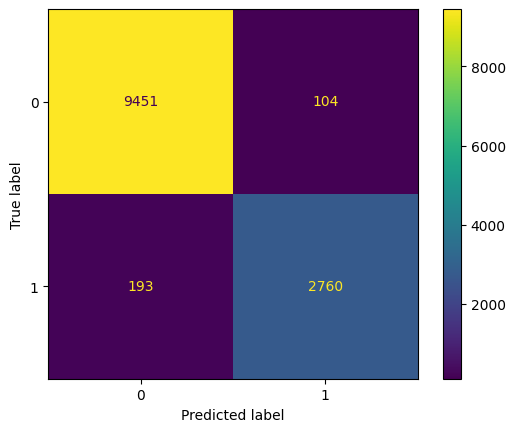

In [14]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(20,),(30,),(25,5),(15,)],'max_iter':[1000]} #(20,),(30,),(40,5),(35,10),(35,5),(35,),(30,5),(25,)


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)

mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [15]:
joblib.dump(mlpc, 'next_month_lapse_model.joblib')

['next_month_lapse_model.joblib']

## Scoring data

In [16]:
new_data = X_test.copy()
pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
new_data['index']=new_data.index
new_data = pd.merge(new_data,pol_names,on='index',how='left')
new_data.drop(columns=['index'],inplace=True)
model_file='next_month_lapse_model.joblib'
next_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next_model.feature_names_in_)].copy()
next_prediction = next_model.predict(score_data)
next_prob = next_model.predict_proba(score_data)

# Next 3 month lapse

In [ ]:
X_train, X_test, Y_train, y_test=data_prep(data_s.copy(),'3month')

## Training model

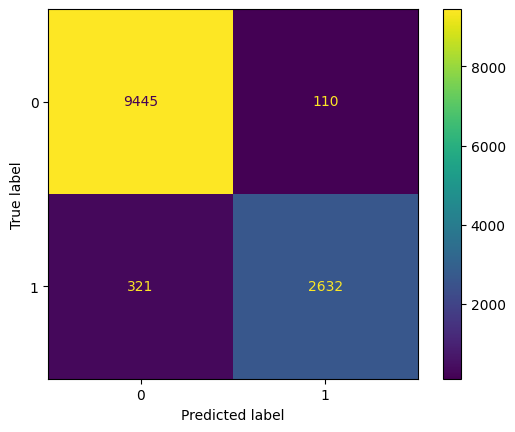

In [27]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(20,),(30,),(25,5),(15,)],'max_iter':[1000]} #(20,),(30,),(40,5),(35,10),(35,5),(35,),(30,5),(25,)


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)

mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [28]:
joblib.dump(mlpc, 'next_3month_lapse_model.joblib')

['next_3month_lapse_model.joblib']

## Scoring data

In [29]:
model_file='next_3month_lapse_model.joblib'
next3_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next3_model.feature_names_in_)].copy()
next3_prediction = next3_model.predict(score_data)
next3_prob = next3_model.predict_proba(score_data)


# Scored data

In [30]:
new_data['next month lapse prediction']=next_prediction
new_data['next month lapse prob']=next_prob[:,1]
new_data['next 3 month lapse prediction']=next3_prediction
new_data['next 3 month lapse prob']=next3_prob[:,1]
new_data.to_csv(path+'scored_data_nearftr.csv')